In [28]:
from src.visualisation import PatientSnapshot

import SimpleITK as sitk
import sys
import time
import os
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# reader = sitk.ImageSeriesReader()
# dicom_names = reader.GetGDCMSeriesFileNames('../data/1')
# reader.SetFileNames(dicom_names)
# image = reader.Execute()

# size = image.GetSize()
# print( "Image size:", size[0], size[1], size[2] )

In [30]:
patient_path = '../data/1/'
patient = PatientSnapshot.from_path(patient_path, mask_path=None)

In [4]:
def writeSlices(series_tag_values, new_img, i):
    image_slice = new_img[:,:,i]

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
    image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
    image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # Setting the type to CT preserves the slice location.
    image_slice.SetMetaData("0008|0060", "CT")  # set the type to CT so the thickness is carried over

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020,0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    writer.SetFileName(os.path.join('../temp/',str(i)+'.dcm'))
    writer.Execute(image_slice)

img = sitk.GetImageFromArray(patient.snapshot.astype(np.int16))
img.SetSpacing(patient.spacing)
writer = sitk.ImageFileWriter()
writer.KeepOriginalImageUIDOn()
modification_time = time.strftime("%H%M%S")
modification_date = time.strftime("%Y%m%d")
direction = img.GetDirection()
series_tag_values = [("0008|0031",modification_time), # Series Time
                  ("0008|0021",modification_date), # Series Date
                  ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                  ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                  ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                    direction[1],direction[4],direction[7])))),
                  ("0008|103e", "Created-SimpleITK")] # Series Description
list(map(lambda i: writeSlices(series_tag_values, img, i), range(img.GetDepth())))

data_directory = '../temp/'
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(data_directory)
if not series_IDs:
    print("ERROR: given directory \""+data_directory+"\" does not contain a DICOM series.")
    sys.exit(1)
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(data_directory, series_IDs[0])

series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

series_reader.LoadPrivateTagsOn()
image3D = series_reader.Execute()
print(image3D.GetSpacing(),'vs',img.GetSpacing())

(1.5, 0.9765625, 0.9765625) vs (1.5, 0.9765625, 0.9765625)


## Fast marching cubes

In [5]:
seedPosition = (240, 260)

sigma = float(5.0)
alpha = float(50.0)
beta = float(10.0)
timeThreshold = float(5.0)
stoppingTime = float(50.0)
# inputImage = sitk.ReadImage(inputFilename, sitk.sitkFloat32)
inputImage = image3D

inputImage = sitk.Cast(inputImage, sitk.sitkFloat32)


print(inputImage)

smoothing = sitk.CurvatureAnisotropicDiffusionImageFilter()
smoothing.SetTimeStep(0.125)
smoothing.SetNumberOfIterations(5)
smoothing.SetConductanceParameter(9.0)
smoothingOutput = smoothing.Execute(inputImage)

gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(sigma)
gradientMagnitudeOutput = gradientMagnitude.Execute(smoothingOutput)

sigmoid = sitk.SigmoidImageFilter()
sigmoid.SetOutputMinimum(0.0)
sigmoid.SetOutputMaximum(1.0)
sigmoid.SetAlpha(alpha)
sigmoid.SetBeta(beta)
sigmoid.DebugOn()
sigmoidOutput = sigmoid.Execute(gradientMagnitudeOutput)


fastMarching = sitk.FastMarchingImageFilter()
seedValue = 0
trialPoint = (seedPosition[0], seedPosition[1], seedValue)


fastMarching.AddTrialPoint(trialPoint)

fastMarching.SetStoppingValue(stoppingTime)

fastMarchingOutput = fastMarching.Execute(sigmoidOutput)


thresholder = sitk.BinaryThresholdImageFilter()
thresholder.SetLowerThreshold(0.0)
thresholder.SetUpperThreshold(timeThreshold)
thresholder.SetOutsideValue(0)
thresholder.SetInsideValue(255)

result = thresholder.Execute(fastMarchingOutput)



Image (0x7fcdfe4070d0)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 440844
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 440834
  UpdateMTime: 440843
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 1718]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 1718]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 1718]
  Spacing: [1.5, 0.976562, 0.976562]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
1.5 0 0
0 0.976562 0
0 0 0.976562

  PointToIndexMatrix: 
0.666667 0 0
0 1.024 0
0 0 1.024

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x7fcdfe407360)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Refer

In [13]:
# Фиг знает что с этим делать дальше, оно никуда не конвертится
# print(result)

## Watershed

In [33]:
img = sitk.GetImageFromArray(patient.snapshot[-200].astype(np.int16))

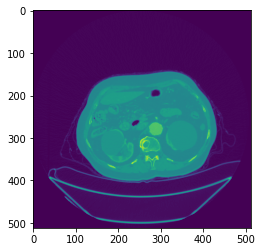

In [34]:
plt.imshow(patient.snapshot[-200])

In [35]:
sigma=img.GetSpacing()[0]
level=4

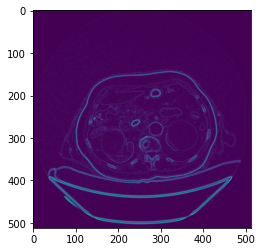

In [36]:
feature_img = sitk.GradientMagnitude(img)
plt.imshow(np.array(feature_img).reshape(512, 512))

In [37]:
pt = [240, 260]
idx = img.TransformPhysicalPointToIndex(pt)
marker_img *= 0
marker_img[0,0] = 1
marker_img[idx] = 2

ws = sitk.MorphologicalWatershedFromMarkers(feature_img, marker_img, markWatershedLine=True, fullyConnected=False)
myshow(sitk.LabelOverlay(img, ws, opacity=.2), "Watershed Oversegmentation from manual markers")

NameError: name 'marker_img' is not defined